# 2.4 - Loss functions in Tensorflow

Course's material requires a `tensorflow` version lower than the default one used in Google Colab. Run the following cell to downgrade TensorFlow accordingly.

In [ ]:
import os
def downgrade_tf_version():
    os.system("!yes | pip uninstall -y tensorflow")
    os.system("!yes | pip install tensorflow==2.12.0")
    os.kill(os.getpid(), 9)
downgrade_tf_version()

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
%matplotlib inline

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
    
tf.__version__

'2.4.0'

### A sample dataset

A very simple regression task, with one input and one output

In [3]:
d = pd.read_csv("local/data/trilotropicos.csv")
y = d.densidad_escamas.values.astype(np.float32)
X = np.r_[[d.longitud.values]].T.astype(np.float32)
X.shape, y.shape

((150, 1), (150,))

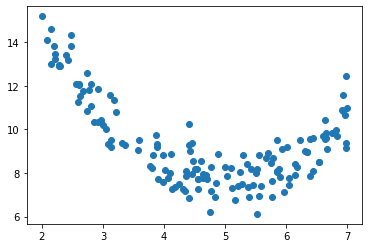

In [4]:
plt.scatter(X, y)

### Linear regression with Tensorflow Sequential API

Observe how we implement a standard **Linear Regression** model with Tensorflow **Sequential** model.

In [5]:

def get_model_sequential(loss):
    model = Sequential()
    model.add(Dense(1, input_shape=(X.shape[-1],), activation="linear"))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss=loss)
    return model  


In [6]:
model = get_model_sequential(loss="mse")
model.fit(X,y, epochs=400, batch_size=16, verbose=0);
model.get_weights()

[array([[-0.7696493]], dtype=float32), array([12.655966], dtype=float32)]

and we can always call the trained model on any input data to make new predictions

In [7]:
model(np.r_[[[5],[6],[7]]]).numpy()

array([[8.807719 ],
       [8.03807  ],
       [7.2684207]], dtype=float32)

In [8]:
model.predict(np.r_[[[5],[6],[7]]])

array([[8.807719 ],
       [8.03807  ],
       [7.2684207]], dtype=float32)

the weights obtained are quite similar with the standard `scikit-learn` implementation

In [9]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X,y)
lr.coef_, lr.intercept_

(array([-0.71805906], dtype=float32), 12.689999)

note we are using the **predefined Mean Squared Error** loss function in Tensorflow

In [10]:
model = get_model_sequential(loss=tf.keras.losses.MSE)
model.fit(X,y, epochs=400, batch_size=16, verbose=0);
model.get_weights()

[array([[-0.72692335]], dtype=float32), array([12.650194], dtype=float32)]

In [11]:
model(np.r_[[[5],[6],[7]]]).numpy()

array([[9.015577],
       [8.288654],
       [7.561731]], dtype=float32)

We could have implemented ourselves. Recall we **MUST USE** Tensorflow operations.

In [12]:
def mse_loss(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2, axis=-1)

In [13]:
model = get_model_sequential(loss=mse_loss)
model.fit(X,y, epochs=400, batch_size=16, verbose=0);
model.get_weights()

[array([[-0.6994947]], dtype=float32), array([12.679553], dtype=float32)]

In [14]:
model(np.r_[[[5],[6],[7]]]).numpy()

array([[9.182079],
       [8.482585],
       [7.78309 ]], dtype=float32)

You can even explicitly call the functions and check how they work

In [15]:
y_true  = np.random.random(size=5)
y_preds = np.random.random(size=y_true.shape)
y_true, y_preds

(array([0.9562911 , 0.07832308, 0.70414816, 0.91567686, 0.23363904]),
 array([0.63817035, 0.97924217, 0.4115003 , 0.55839522, 0.13775806]))

In [16]:
# numpy MSE
np.mean((y_true-y_preds)**2)

0.22706842585597964

In [17]:
# tf.keras MSE
tf.keras.losses.MSE(y_true, y_preds)

<tf.Tensor: shape=(), dtype=float64, numpy=0.22706842585597964>

In [18]:
# our implementation
mse_loss(y_true, y_preds)

<tf.Tensor: shape=(), dtype=float64, numpy=0.22706842585597964>

### Linear regression with Tensorflow Functional API

We can use the same mechanism with the Functional API

In [19]:
def get_model_functional_1(loss):
    inputs = Input(shape=(X.shape[-1],), name="input")
    outputs = Dense(1, activation='linear', name="output")(inputs)
    model = Model([inputs], [outputs])    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss=loss)
    return model  


In [20]:

model = get_model_functional_1(loss="mse")
model.fit(X,y, epochs=400, batch_size=16, verbose=0);
model.get_weights()

[array([[-0.7317973]], dtype=float32), array([12.652348], dtype=float32)]

In [21]:
model(np.r_[[[5],[6],[7]]]).numpy()

array([[8.993361 ],
       [8.261564 ],
       [7.5297666]], dtype=float32)

In [22]:
model = get_model_functional_1(loss=tf.keras.losses.MSE)
model.fit(X,y, epochs=400, batch_size=16, verbose=0);
model.get_weights()

[array([[-0.7890887]], dtype=float32), array([12.644999], dtype=float32)]

In [23]:
model(np.r_[[[5],[6],[7]]]).numpy()

array([[8.699554 ],
       [7.910466 ],
       [7.1213775]], dtype=float32)

In [24]:
model = get_model_functional_1(loss=mse_loss)
model.fit(X,y, epochs=400, batch_size=16, verbose=0);
model.get_weights()

[array([[-0.7223748]], dtype=float32), array([12.674201], dtype=float32)]

In [25]:
model(np.r_[[[5],[6],[7]]]).numpy()

array([[9.062326 ],
       [8.339952 ],
       [7.6175776]], dtype=float32)

However, when using the Functional API we have more flexibility. The following code is **an orthodox** way
of defining a supervised model, but it will be useful when dealing with Autoencoders later on to use them in an unsupervised manner. 

Observe the following aspects:

- We **DEFINE** our model to have two inputs: $X$ (on layer `inputs`) and $y$ (on layer `targets`).
- We **DEFINE** our model to have one output on layer `outputs` just like before. Observe that the new layer `targets` does not participate in producing this output.
- We **INTEGRATE** the loss into the model by using directly **the model layers** and the `model.add_loss` method.
- We **DO NOT** need to specify the `loss` when compiling the model.
- The `targets` layer only participates in computing the `loss` and, thus, it is only used during **TRAINING**, not on inference.

In [26]:
def get_model_functional_2():
    inputs  = Input(shape=(X.shape[-1],), name="inputs")
    targets = Input(shape=(1,), name="targets")
    
    outputs = Dense(1, activation='linear', name="outputs")(inputs)
    model = Model([inputs, targets], [outputs])    
    
    loss = tf.reduce_mean((outputs-targets)**2)
    model.add_loss(loss)

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))
    return model  


observe how, due to this new architecture, the call to the `.fit` method now changes, although the results are the same.

In [27]:
model = get_model_functional_2()
model.fit([X,y], epochs=400, batch_size=16, verbose=0);
model.get_weights()

[array([[-0.7307422]], dtype=float32), array([12.66002], dtype=float32)]

**HOWEVER** when calling the model (inference) we **MUST** provide both $X$ and $y$, even if we know that $y$ will not be used (it is only used when training). Observe how the following call always yields the same result regardless the values of $y$. 

This is **INCONVENIENT** for a supervised model, but illustrates the flexibility of the functional API.

In [30]:
X = np.r_[[[5],[6],[7]]]
y = np.random.random(size=(3,1))
print (y)
model([X, y]).numpy()

[[0.58962311]
 [0.48533767]
 [0.14276567]]


array([[9.006309 ],
       [8.275566 ],
       [7.5448246]], dtype=float32)